In [1]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image

import numpy as np
import os
import time

/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:594: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:
model_path = 'deepseek-ai/Janus-Pro-1B'
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'
#cuda_device = 'cpu'
if cuda_device == 'cuda':
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: sft_format, num_image_tokens, add_special_t

In [3]:
def multimodal_understanding(image, question, seed, top_p, temperature):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = load_pil_images(conversation)
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16)
    
    
    inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
    
    outputs = vl_gpt.language_model.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=prepare_inputs.attention_mask,
        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,
        do_sample=False if temperature == 0 else True,
        use_cache=True,
        temperature=temperature,
        top_p=top_p,
    )
    
    answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
    return answer


In [4]:
from IPython.display import display
from urllib.request import urlopen

image_path = '/home/rmuproject/rmuproject/users/sandesh/FinetunedSDIVP/scripts/Hareque.png'
# init_image = Image.open(image_path).convert("RGB")
answer = multimodal_understanding (
    image = image_path,
    question='describe the image',
    seed = 123,
    top_p = 0.8,
    temperature = 1.0
   )
answer 

'The image depicts a complex geometric pattern composed of interconnected floral-like shapes. The design appears to be abstract, featuring a combination of overlapping lines and curves to form intricate flower forms. The background consists of a gradient, transitioning from a darker blue at the top to a lighter blue and green towards the left side. The overall color palette includes shades of blue and green, giving the image a calming and artistic feel. The pattern is dense and occupies most of the visual space, creating a sense of depth and complexity.'

In [5]:
# Name of the variable to keep
keep_variable = 'answer'

# Get a list of all variables in the global scope
all_variables = list(globals().keys())

# Delete all variables except the one to keep
for var in all_variables:
    if var != keep_variable and not var.startswith('_'):
        del globals()[var]

In [6]:
answer

'The image depicts a complex geometric pattern composed of interconnected floral-like shapes. The design appears to be abstract, featuring a combination of overlapping lines and curves to form intricate flower forms. The background consists of a gradient, transitioning from a darker blue at the top to a lighter blue and green towards the left side. The overall color palette includes shades of blue and green, giving the image a calming and artistic feel. The pattern is dense and occupies most of the visual space, creating a sense of depth and complexity.'

In [7]:
import torch
import requests
from PIL import Image

from diffusers import StableDiffusionDepth2ImgPipeline

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', giving the image a calming and artistic feel . the pattern is dense and occupies most of the visual space , creating a sense of depth and complexity .']


100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


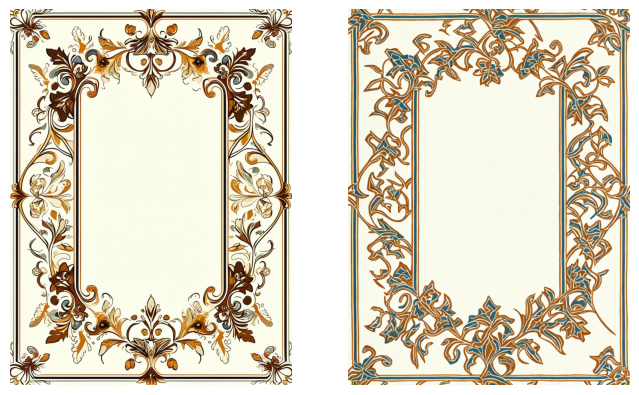

In [14]:
image_path = '/home/rmuproject/rmuproject/users/sandesh/Depth-to-Image/PatternVerse Test Set - II/49.jpg'
# init_image = Image.open(requests.get(url, stream=True).raw)
init_image = Image.open(image_path).convert("RGB")
prompt = answer
n_prompt = "bad, deformed, ugly, bad anotomy"
image = pipe(prompt=prompt, image=init_image, negative_prompt=n_prompt, strength=0.7).images[0]
image.save("generated_image.png")

# Display the image
# image.show()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 12))
ax[0].imshow(init_image)
ax[1].imshow(image)
ax[0].axis("off")
ax[1].axis("off")
plt.show()